# AHP


In [478]:
import csv
import numpy as np
import pandas as pd
import graphviz


pd.set_option("display.float_format", lambda x: "%.4f" % x)

In [479]:
header = []
ids = []
data = []
with open("data.csv", "r") as f:
    reader = csv.reader(f)
    header = next(reader)[1:]
    for row in reader:
        name = row[0]
        ids.append(name)
        data.append(list(map(float, row[1:])))
data = np.array(data)
ids = np.array(ids)

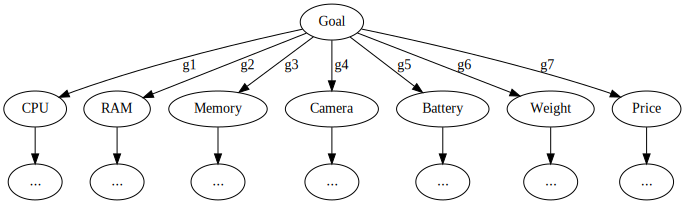

In [480]:
d = graphviz.Digraph()

for index, criteria in enumerate(header):
    d.edge("Goal", criteria, f"g{index+1}")
    d.node(str(index), "...")
    d.edge(criteria, str(index))

d

In [519]:
A = np.array(
    [  # C  R  S  C	 B  W, P
        [1, 0, 1, 1, 0, 2, 3],  # CPU
        [3, 1, 0, 1, 0, 2, 2],  # RAM
        [0, 2, 1, 3, 0, 3, 5],  # Storage
        [0, 0, 0, 1, 0, 2, 4],  # Camera
        [2, 2, 2, 2, 1, 9, 7],  # Battery
        [0, 0, 0, 0, 0, 1, 2],  # Weight
        [0, 0, 0, 0, 0, 0, 1],  # Price
    ],
    np.float32,
)

for m in range(A.shape[0]):
    for n in range(A.shape[1]):
        if A[m, n] == 0:
            A[m, n] = 1 / A[n, m]

pd.DataFrame(A, columns=header, index=header)

,CPU,RAM,Memory,Camera,Battery,Weight,Price
CPU,1.0000,0.3333,1.0000,1.0000,0.5000,2.0000,3.0000
RAM,3.0000,1.0000,0.5000,1.0000,0.5000,2.0000,2.0000
Memory,1.0000,2.0000,1.0000,3.0000,0.5000,3.0000,5.0000
Camera,1.0000,1.0000,0.3333,1.0000,0.5000,2.0000,4.0000
Battery,2.0000,2.0000,2.0000,2.0000,1.0000,9.0000,7.0000
Weight,0.5000,0.5000,0.3333,0.5000,0.1111,1.0000,2.0000
Price,0.3333,0.5000,0.2000,0.2500,0.1429,0.5000,1.0000


## Calculation of weights


In [521]:
def get_weights_1(A):
    return (A / A.sum(axis=0)).sum(axis=1) / len(A)


pd.DataFrame(get_weights_1(A), index=header, columns=["Weight"])

,Weight
CPU,0.1201
RAM,0.1461
Memory,0.2044
Camera,0.1213
Battery,0.3087
Weight,0.0590
Price,0.0404


In [520]:
def get_weights_2(A, rank=2):
    for _ in range(rank - 1):
        A = np.dot(A, A)
    row_sum = A.sum(axis=1)
    return row_sum / row_sum.sum()


pd.DataFrame(get_weights_2(A, 5), index=header, columns=["Weight"])

,Weight
CPU,0.1198
RAM,0.1461
Memory,0.2040
Camera,0.1200
Battery,0.3111
Weight,0.0588
Price,0.0403


The weights represent the preference that we have intended to show pretty accurately. _Battery_ is important, while _weight_ is not. Also we would like to have sufficient amount of _memory_ in the phone.


## Consistency check


In [484]:
def is_consistent(A, RI):
    eigenvalues, _ = np.linalg.eig(A)
    max_eigenvalue = max(eigenvalues)
    CI = (max_eigenvalue - len(A)) / (len(A) - 1)
    CR = CI / RI
    print(f"Max eigenvalue: {max_eigenvalue}")
    print(f"CI: {CI}")
    print(f"CR: {CR}")
    return CR <= 0.1


RI_7 = 1.32
is_consistent(A, RI_7)

Max eigenvalue: (7.398891448974609+0j)
CI: (0.06648190816243489+0j)
CR: (0.05036508194123855+0j)


True

Examples from the lecture slides:


In [485]:
is_consistent(
    np.array(
        [
            [1, 1 / 3, 1, 3],
            [3, 1, 3, 9],
            [1, 1 / 3, 1, 3],
            [1 / 3, 1 / 9, 1 / 3, 1],
        ],
    ),
    0.9,
)

Max eigenvalue: (3.999999999999999+0j)
CI: (-2.9605947323337506e-16+0j)
CR: (-3.289549702593056e-16+0j)


True

In [486]:
is_consistent(
    np.array(
        [
            [1, 2, 5, 1],
            [1 / 2, 1, 3, 2],
            [1 / 5, 1 / 3, 1, 1 / 4],
            [1, 1 / 2, 4, 1],
        ],
    ),
    0.9,
)

Max eigenvalue: (4.191275054974821+0j)
CI: (0.06375835165827373+0j)
CR: (0.07084261295363749+0j)


True

## Recreating an inconsistent matrix


In [ ]:
Ac = A

Modify the preference matrix to make it inconsistent. See the delta between two matrices:


In [518]:
A = np.array(
    [  # C  R  S  C	 B  W, P
        [1, 0, 4, 9, 0, 2, 3],  # CPU
        [3, 1, 0, 7, 0, 9, 2],  # RAM
        [0, 2, 1, 3, 0, 3, 5],  # Storage
        [0, 0, 0, 1, 0, 2, 4],  # Camera
        [2, 2, 2, 2, 1, 9, 7],  # Battery
        [0, 0, 0, 0, 0, 1, 2],  # Weight
        [0, 0, 0, 0, 0, 0, 1],  # Price
    ],
    np.float32,
)

for m in range(A.shape[0]):
    for n in range(A.shape[1]):
        if A[m, n] == 0:
            A[m, n] = 1 / A[n, m]

pd.DataFrame(A - Ac, columns=header, index=header).style.map(
    lambda value: "color: green" if value > 0 else None
)

,CPU,RAM,Memory,Camera,Battery,Weight,Price
CPU,0.000000,0.000000,3.000000,8.000000,0.000000,0.000000,0.000000
RAM,0.000000,0.000000,0.000000,6.000000,0.000000,7.000000,0.000000
Memory,-0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Camera,-0.888889,-0.857143,0.000000,0.000000,0.000000,0.000000,0.000000
Battery,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Weight,0.000000,-0.388889,0.000000,0.000000,0.000000,0.000000,0.000000
Price,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [488]:
is_consistent(A, RI_7)

Max eigenvalue: (8.540485382080078+0j)
CI: (0.256747563680013+0j)
CR: (0.19450573006061592+0j)


False

Obtained weights:


In [514]:
weights = get_weights_2(A, 5)
pd.DataFrame(weights, index=header, columns=["Weight"])

,Weight
CPU,0.2108
RAM,0.2309
Memory,0.1531
Camera,0.0632
Battery,0.2610
Weight,0.0424
Price,0.0385


Reconstructed preference matrix:


In [516]:
reconstructed = np.zeros((len(weights), len(weights)))
for i in range(len(weights)):
    for j in range(len(weights)):
        reconstructed[i, j] = weights[i] / weights[j]

pd.DataFrame(reconstructed, columns=header, index=header)

,CPU,RAM,Memory,Camera,Battery,Weight,Price
CPU,1.0000,0.9131,1.3767,3.3331,0.8079,4.9706,5.4695
RAM,1.0952,1.0000,1.5078,3.6505,0.8848,5.4439,5.9903
Memory,0.7264,0.6632,1.0000,2.4210,0.5868,3.6104,3.9728
Camera,0.3000,0.2739,0.4130,1.0000,0.2424,1.4913,1.6410
Battery,1.2378,1.1302,1.7041,4.1258,1.0000,6.1526,6.7702
Weight,0.2012,0.1837,0.2770,0.6706,0.1625,1.0000,1.1004
Price,0.1828,0.1669,0.2517,0.6094,0.1477,0.9088,1.0000


Difference between the pairwise comparison matrix and the reconstructed one. Marked are the most significant differences:


In [517]:
pd.DataFrame(A - reconstructed, columns=header, index=header).style.map(
    lambda value: "color: green" if abs(value) > 2.5 else None
)

,CPU,RAM,Memory,Camera,Battery,Weight,Price
CPU,0.000000,-0.579719,2.623280,5.666892,-0.307877,-2.970580,-2.469482
RAM,1.904772,0.000000,-1.007822,3.349487,-0.384809,3.556083,-3.990328
Memory,-0.476364,1.336792,0.000000,0.578950,-0.086813,-0.610450,1.027166
Camera,-0.188909,-0.131077,-0.079711,0.000000,0.257621,0.508726,2.359045
Battery,0.762188,0.869813,0.295878,-2.125763,0.000000,2.847355,0.229807
Weight,0.298816,-0.072580,0.056360,-0.170567,-0.051421,0.000000,0.899629
Price,0.150501,0.333064,-0.051709,-0.359401,-0.004849,-0.408784,0.000000


As we may see, the reconstructed matrix has to some extend addressed/undone the changes that have been made to make it inconsistent in the first place.